In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from jazzy.api import molecular_vector_from_smiles, atomic_map_from_smiles
from jazzy.core import kallisto_molecule_from_rdkit_molecule, get_charges_from_kallisto_molecule, calculate_polar_strength_map, get_covalent_atom_idxs, rdkit_molecule_from_smiles
from sklearn.metrics import mean_absolute_error
from scipy import stats
import svgutils.transform as sg

class HorizontalDisplay:
    """
    Accepts a list of SVGs, concatenates them, and returns a horizonal rendering.
    """
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        concat_svgs = ''.join(self.args[0])
        template = '<div style="">{}</div>'
        return template.format(concat_svgs)

def plot_charges(mol, charges, sa_max, pKBHX, title):

    Chem.rdDepictor.Compute2DCoords(mol)    # Flatten molecule

    # Add partial charge label to selected indices
    for a in mol.GetAtoms():
        idx = a.GetIdx()

        lbl = '%.2f'%(charges[idx])
        a.SetProp('atomNote', str(lbl))
        d2d = Chem.Draw.rdMolDraw2D.MolDraw2DSVG(200, 300)
        d2d.drawOptions().annotationFontScale = 0.5
        d2d.DrawMolecule(mol)
        d2d.FinishDrawing()

    # Add ligand name as a title
    img_text = d2d.GetDrawingText()
    img_text = img_text.replace('svg:','')
    fig = sg.fromstring(img_text)
    label = sg.TextElement(100, 10, title, size=14, 
                        font='sans-serif', anchor='middle', color='#000000')
    fig.append(label)
    label = sg.TextElement(100, 25, "Sa_max: {}".format(sa_max), size=14, 
                        font='sans-serif', anchor='middle', color='#000000')
    fig.append(label)
    label = sg.TextElement(100, 45, "pKBHX: {}".format(pKBHX), size=14, 
                        font='sans-serif', anchor='middle', color='#000000')
    fig.append(label)
    
    img_text = fig.to_str().decode("utf-8")
    
    return img_text

def MolsFromSpartanFiles(file):
    '''
    Function to read in multi-molecule mol2 files generated by Spartan
    Molecules look weird when importing but connectivity fine.

    New coordinates generated using rdkit 
    '''
    with open(file,"r") as f:
            mol2 = f.readlines()

    starts = []
    for i,line in enumerate(mol2):
        if line.find("#	File Created by: Spartan'20 Export") != -1:
            starts.append(i-1)
    starts.append(len(mol2))

    mols = []
    for i in range(len(starts)-1):
        mol = Chem.MolFromMol2Block("".join(mol2[starts[i]:starts[i+1]]), removeHs=False)
        Chem.AllChem.Compute2DCoords(mol)
        Chem.AllChem.EmbedMolecule(mol)
        Chem.AllChem.MMFFOptimizeMolecule(mol)

        Chem.rdPartialCharges.ComputeGasteigerCharges(mol, nIter=50)
        mols.append(mol)
        
    return mols

#### Output SDF for QM calculations

In [6]:
df = pd.read_csv("../data/acceptor_strengths/pKBHX_data_pwk19aug2016.txt",sep=" ")

sa = []
sa_max = []

#
for smiles in df["#SMILES"]:
    try:
        sa.append(molecular_vector_from_smiles(smiles, "MMFF94")["sa"])
    except:
        sa.append(None)

df["sa"] = sa

df.dropna(subset="sa", inplace=True)

mols = [Chem.MolFromSmiles(x) for x in df["#SMILES"]]

df.to_csv("../data/acceptor_strengths/pKBHX_processed.csv", index=False)

writer = Chem.SDWriter("../data/acceptor_strengths/all_mols.sdf")
for mol in mols:
    mol = Chem.AllChem.AddHs(mol)
    Chem.AllChem.EmbedMolecule(mol)
    Chem.AllChem.MMFFOptimizeMolecule(mol)
    writer.write(mol)

writer.close()

Jazzy ERROR: [15:51:50] The RDKit embedding has failed for the molecule: C1C2CC3CC1CC(C2)C34C5(C6CC7CC(C6)CC5C7)OO4
[15:51:57] UFFTYPER: Unrecognized charge state for atom: 2
[15:52:01] UFFTYPER: Unrecognized charge state for atom: 1
[15:52:07] UFFTYPER: Unrecognized charge state for atom: 2
[15:52:08] UFFTYPER: Unrecognized charge state for atom: 1


#### Analysis

[15:59:49] M0004: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[15:59:49] M0005: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[15:59:50] UFFTYPER: Unrecognized charge state for atom: 2
[15:59:51] UFFTYPER: Unrecognized charge state for atom: 1
[15:59:51] M0356: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[15:59:51] M0357: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[15:59:56] M0004: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[15:59:56] M0005: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[15:59:57] UFFTYPER: Unrecognized charge state for atom: 2
[15:59:58] UFFTYPER: Unrecognized charge state for atom: 1
[15:59:58] M0356: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[15:59:58] M0357: Warning - no expli

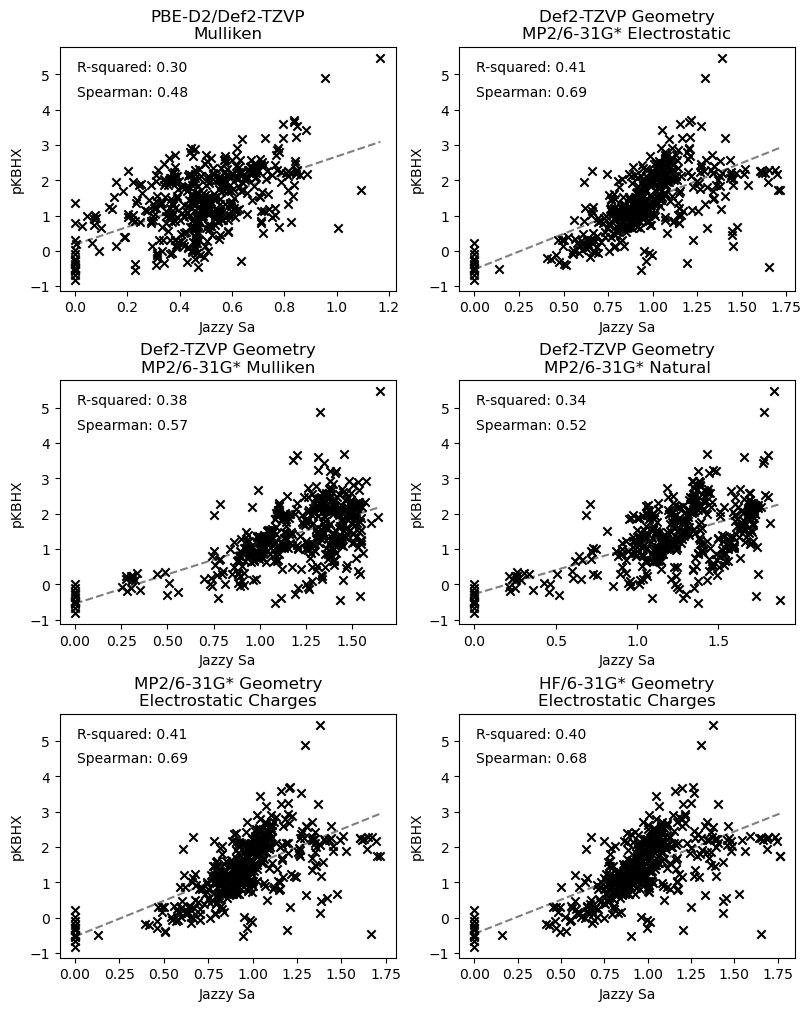

In [11]:
## Compare Charge Performance between DFT levels of theory

df = pd.read_csv("../data/acceptor_strengths/pKBHX_processed.csv")

strengths = []
charges = []

for file in ["all_mols_PBE_mulliken.mol2","all_mols_MP2_Electrostatic.mol2","all_mols_MP2_mulliken.mol2","all_mols_MP2_natural.mol2","all_mols_MP2_631Gopt.mol2","all_mols_HF631G.mol2"]:
    file = "../data/acceptor_strengths/"+file

    mols = MolsFromSpartanFiles(file)
    dft_charges =[]
    dft_strengths = []

    for k,mol in enumerate(mols):
        try:
            # get partial charges
            
            mol_dft =[]


            for atom in mol.GetAtoms():
                mol_dft.append(float(atom.GetProp('_TriposPartialCharge')))
            
            dft_charges.append(mol_dft)

            ### Calculate acceptor strengths by different charge methods

            atoms_and_nbrs = get_covalent_atom_idxs(mol)

            kmol = kallisto_molecule_from_rdkit_molecule(mol)
            
            mol_sa_dft = []

            for chrg_list, sa_list in zip([mol_dft], [mol_sa_dft]):
                strength_map = calculate_polar_strength_map(mol, kmol, atoms_and_nbrs, chrg_list)
                
                for i in range(len(strength_map.keys())):
                    sa_list.append(strength_map[i]["sa"])

            dft_strengths.append(mol_sa_dft)

        except:
            continue

    strengths.append(dft_strengths)
    charges.append(dft_charges)

fig, axs = plt.subplots(3,2, figsize=(8,10), layout="constrained")

titles = ["PBE-D2/Def2-TZVP\nMulliken","Def2-TZVP Geometry\nMP2/6-31G* Electrostatic","Def2-TZVP Geometry\nMP2/6-31G* Mulliken","Def2-TZVP Geometry\nMP2/6-31G* Natural","MP2/6-31G* Geometry\nElectrostatic Charges","HF/6-31G* Geometry\nElectrostatic Charges"]

for i, str_df in enumerate(strengths):

    max_sa = [max(x) for x in str_df]
    axs.flatten()[i].scatter(max_sa, df["pKBHX"], color="black", marker="x")
    
    # Linear regression and R-squared calculation
    slope, intercept, r_value, p_value, std_err = stats.linregress([max(x) for x in str_df], df.pKBHX)
    r_squared = r_value ** 2

    spearman, p_value = stats.spearmanr([max(x) for x in str_df], df.pKBHX)
    
    # Annotate with R-squared value
    axs.flatten()[i].annotate(f"R-squared: {r_squared:.2f}", xy=(0.05, 0.9), xycoords='axes fraction')
    axs.flatten()[i].annotate(f"Spearman: {spearman:.2f}", xy=(0.05, 0.8), xycoords='axes fraction')

    axs.flatten()[i].set_ylabel("pKBHX")    
    axs.flatten()[i].set_title(titles[i])
    axs.flatten()[i].set_xlabel("Jazzy Sa")

    x = np.linspace(0, max(max_sa))
    y = slope*x + intercept
    axs.flatten()[i].plot(x,y, ls="--", color="black", alpha=0.5)

plt.show()

#### Analysis of MSE of Jazzy, Gasteiger and MMFF94 compared to partial charges from PBE-D2/Def2-TZVP geometry and MP2/6-31G* partial charges

In [13]:
with open("../data/acceptor_strengths/all_mols_MP2_631Gopt.mol2","r") as f:
    mol2 = f.readlines()

am1bcc_charges = open("../data/acceptor_strengths/am1bcc_charges.txt").readlines()
am1bcc_charges = [[float(y) for y in x.split(",")] for x in am1bcc_charges]

starts = []
for i,line in enumerate(mol2):
    if line.find("#	File Created by: Spartan'20 Export") != -1:
        starts.append(i-1)
starts.append(len(mol2))

mols = []
for i in range(len(starts)-1):
    mol = Chem.MolFromMol2Block("".join(mol2[starts[i]:starts[i+1]]), removeHs=False)
    Chem.AllChem.Compute2DCoords(mol)
    Chem.AllChem.EmbedMolecule(mol)
    Chem.AllChem.MMFFOptimizeMolecule(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol, nIter=50)
    mols.append(mol)

dft_charges =[]
rdkit_charges = []
jazzy_charges = []
MMFF_charges = []
atom_types = []

dft_strengths = []
rdkit_strengths = []
jazzy_strengths = []
j_smiles_strengths = []
mmff_strengths = []
am1_strengths = []

no_mmff = []
correction = 0

for k,mol in enumerate(mols):
    try:
        # get partial charges
            
        mol_dft =[]
        mol_rdkit = []
        mol_atypes = []
        mol_MMFF94 = []
        mol_am1 = am1bcc_charges[k-correction]
        
        props = Chem.AllChem.MMFFGetMoleculeProperties(mol)
        for i in range(len(mol.GetAtoms())):
            mol_MMFF94.append(props.GetMMFFPartialCharge(i))
        
        MMFF_charges.append(mol_MMFF94)


        for atom in mol.GetAtoms():
            mol_dft.append(float(atom.GetProp('_TriposPartialCharge')))
            mol_rdkit.append(float(atom.GetProp('_GasteigerCharge')))

            # Spartan doesn't assign aromatic atom types

            atom_type = atom.GetProp('_TriposAtomType')
            if atom_type.endswith(".2") and atom.GetIsAromatic():
                mol_atypes.append(atom_type[:-2]+".ar")
            else:
                mol_atypes.append(atom_type)

        dft_charges.append(mol_dft)
        rdkit_charges.append(mol_rdkit)
        atom_types.append(mol_atypes)

        kmol = kallisto_molecule_from_rdkit_molecule(mol)
        atoms_and_nbrs = get_covalent_atom_idxs(mol)
        mol_jazzy = get_charges_from_kallisto_molecule(kmol, 0)
        jazzy_charges.append(mol_jazzy)

        ### Calculate acceptor strengths by different charge methods

        mol_sa_rdkit = []
        mol_sa_jazzy = []
        mol_sa_MMFF = []
        mol_sa_dft = []
        mol_sa_am1 = []

        for chrg_list, sa_list in zip([mol_rdkit, mol_jazzy, mol_MMFF94, mol_dft, mol_am1], [mol_sa_rdkit, mol_sa_jazzy, mol_sa_MMFF, mol_sa_dft, mol_sa_am1]):
            strength_map = calculate_polar_strength_map(mol, kmol, atoms_and_nbrs, chrg_list)
            
            for i in range(len(strength_map.keys())):
                sa_list.append(strength_map[i]["sa"])

        dft_strengths.append(mol_sa_dft)
        rdkit_strengths.append(mol_sa_rdkit)
        jazzy_strengths.append(mol_sa_jazzy)
        mmff_strengths.append(mol_sa_MMFF) 
        am1_strengths.append(mol_sa_am1)
    except:
        no_mmff.append(k)
        correction += 1

# Remove failed molecules from df and mols

df = df.iloc[[x for x in range(len(df)) if x not in no_mmff]].reset_index(drop=True)

mols = [mol for i, mol in enumerate(mols) if i not in no_mmff]

[16:02:58] M0004: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[16:02:58] M0005: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[16:02:59] UFFTYPER: Unrecognized charge state for atom: 2
[16:02:59] UFFTYPER: Unrecognized charge state for atom: 1
[16:03:00] M0356: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[16:03:00] M0357: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


0.15693673735689373 1
0.209727721879904 1
0.19689408430318886 1
0.15020399744874757 1
0.13589378331812446 2
0.20100788823351032 2
0.19092359248102916 2
0.15320513898135055 2


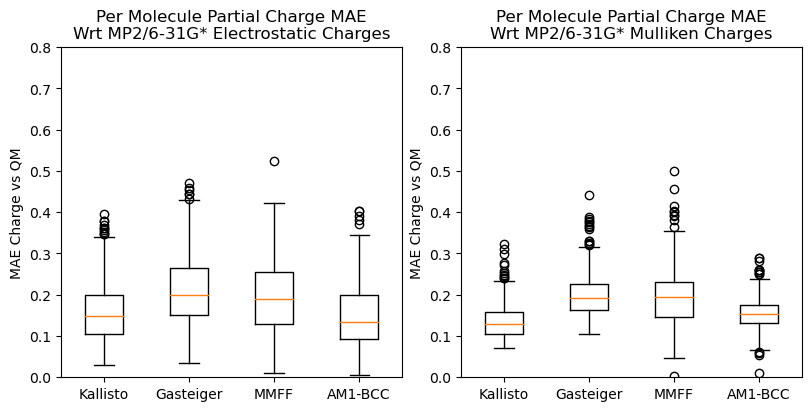

In [14]:
# per mol MSE

fig, ax = plt.subplots(1,2, layout="constrained", figsize=(8,4))

charge_methods = ["Electrostatic","Mulliken"]

for j in [1,2]:
    jazzy_mse = []
    rdkit_mse = []
    mmff_mse = []
    am1_mse = []
    

    for i in range(len(jazzy_charges)):
        dft_list = [x for i, x in enumerate(charges[j]) if i not in no_mmff]
        jazzy_mse.append(mean_absolute_error(jazzy_charges[i], dft_list[i]))
        rdkit_mse.append(mean_absolute_error(dft_list[i], rdkit_charges[i]))
        mmff_mse.append(mean_absolute_error(dft_list[i], MMFF_charges[i]))
        am1_mse.append(mean_absolute_error(dft_list[i], am1bcc_charges[i]))

    ax[j-1].boxplot([jazzy_mse, rdkit_mse, mmff_mse, am1_mse])
    print(np.mean(jazzy_mse),j)
    print(np.mean(rdkit_mse),j)
    print(np.mean(mmff_mse),j)
    print(np.mean(am1_mse),j)


    ax[j-1].set_xticklabels(["Kallisto","Gasteiger","MMFF","AM1-BCC"])

    ax[j-1].set_ylabel("MAE Charge vs QM")
    ax[j-1].set_title(f"Per Molecule Partial Charge MAE\nWrt MP2/6-31G* {charge_methods[j-1]} Charges")
    ax[j-1].set_ylim(0,0.8)
    
plt.show("./reports/MAE_charges.png")

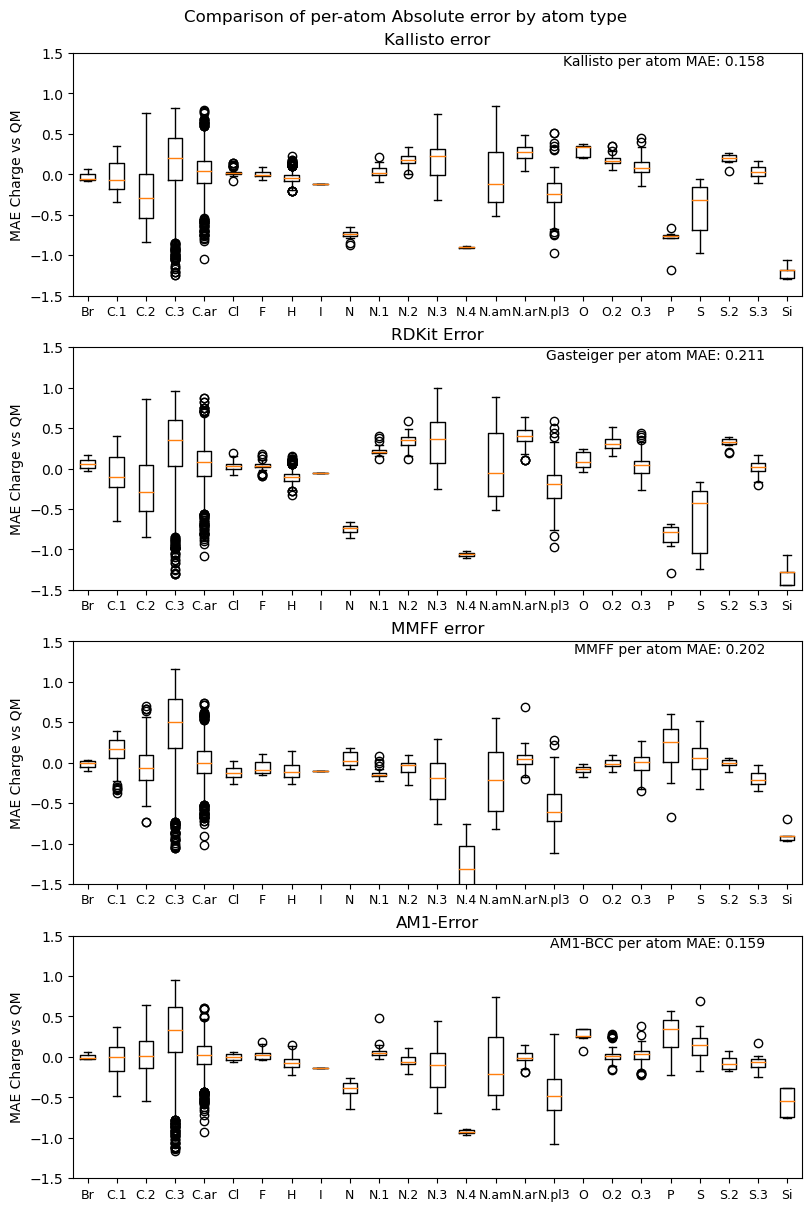

In [15]:
# MSE per atom_type

dft_ = np.concatenate(dft_charges)
rdkit_ = np.concatenate(rdkit_charges)
jazzy_ = np.concatenate(jazzy_charges)
mmff_ = np.concatenate(MMFF_charges)
am1_ = np.concatenate(am1bcc_charges)
at_ = np.concatenate(atom_types)

name = ["Kallisto","Gasteiger","MMFF","AM1-BCC"] 
chrgs = [jazzy_,rdkit_,mmff_, am1_]

aterr_rdkit = []
aterr_jazzy =[]
aterr_mmff = []
aterr_am1 = []
for at in np.unique(at_):
    idx = np.where(at_ == at)[0]

    aterr_rdkit.append(rdkit_[idx] - dft_[idx])
    aterr_jazzy.append(jazzy_[idx] - dft_[idx])
    aterr_mmff.append(mmff_[idx] - dft_[idx])
    aterr_am1.append(am1_[idx] - dft_[idx])

fig, axs = plt.subplots(4,1,figsize=(8,12), layout="constrained")
axs[0].boxplot(aterr_jazzy)
axs[1].boxplot(aterr_rdkit)
axs[2].boxplot(aterr_mmff)
axs[3].boxplot(aterr_am1)

titles = ["Kallisto error", "RDKit Error","MMFF error","AM1-Error"]
for i,ax in enumerate(axs.flatten()):
    ax.set_ylabel("MAE Charge vs QM")
    ax.set_xticklabels(np.unique(at_), fontsize=9)
    ax.set_title(titles[i])
    ax.text(0.95,0.95,f"{name[i]} per atom MAE: {mean_absolute_error(chrgs[i], dft_):.3f}", transform=ax.transAxes, ha="right")
    ax.set_ylim(-1.5,1.5)

fig.suptitle("Comparison of per-atom Absolute error by atom type")
plt.show()

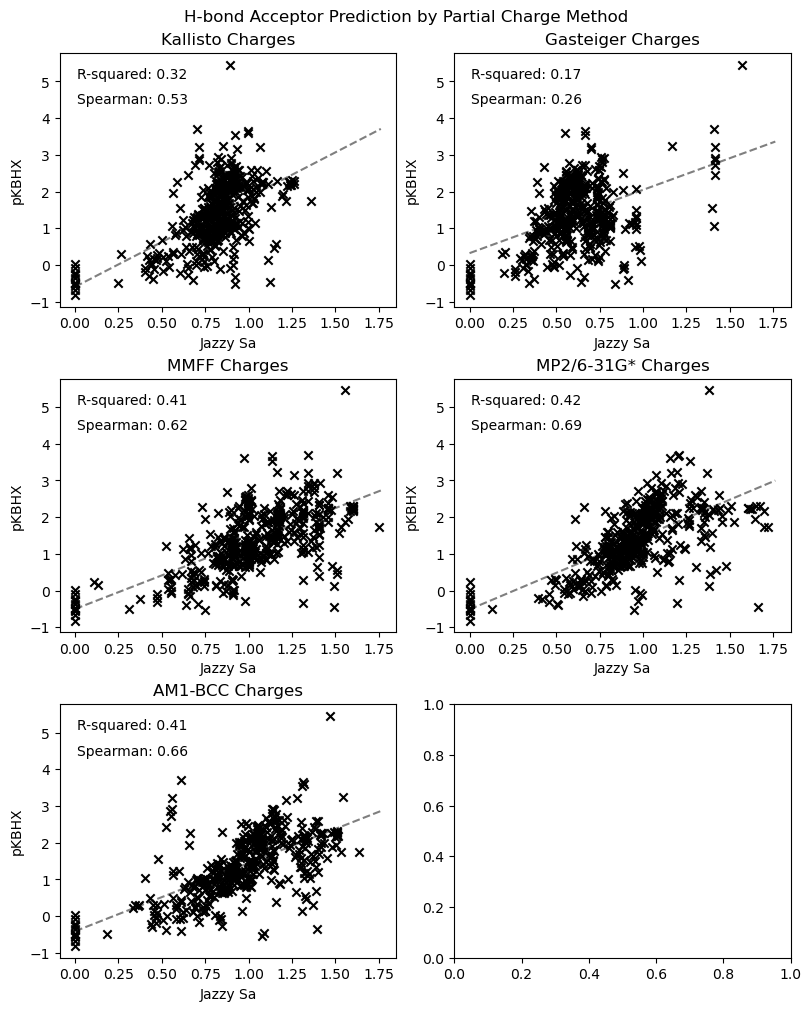

In [16]:
# Comparison of Acceptor Strengths by different Charge Methods

fig, axs = plt.subplots(3,2, figsize=(8,10), layout="constrained")
titles = ["Kallisto Charges", "Gasteiger Charges", "MMFF Charges", "MP2/6-31G* Charges","AM1-BCC Charges"]

strength_dfs = [jazzy_strengths, rdkit_strengths, mmff_strengths, dft_strengths, am1_strengths]
for i, ax in enumerate(axs.flatten()[:5]):
    ax.scatter([max(x) for x in strength_dfs[i]], df.pKBHX, color="black", marker="x")

    # Linear regression and R-squared calculation
    slope, intercept, r_value, p_value, std_err = stats.linregress([max(x) for x in strength_dfs[i]], df.pKBHX)
    r_squared = r_value ** 2

    spearman, p_value = stats.spearmanr([max(x) for x in strength_dfs[i]], df.pKBHX)
    
    # Annotate with R-squared value
    ax.annotate(f"R-squared: {r_squared:.2f}", xy=(0.05, 0.9), xycoords='axes fraction')
    ax.annotate(f"Spearman: {spearman:.2f}", xy=(0.05, 0.8), xycoords='axes fraction')

    x = np.linspace(0, max(max_sa))
    y = slope*x + intercept
    ax.plot(x,y, ls="--", color="black", alpha=0.5)

    ax.set_ylabel("pKBHX")    
    ax.set_title(titles[i])
    ax.set_xlabel("Jazzy Sa")

fig.suptitle("H-bond Acceptor Prediction by Partial Charge Method")
plt.show()